In [46]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [47]:
train_dataset = 'data/train.csv'
test_dataset = 'data/test.csv'
model_save_path = 'model/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier.tflite'

# Set number of classes

In [48]:
NUM_CLASSES = 32

# Dataset reading

In [49]:
X_train = np.loadtxt(train_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_test = np.loadtxt(test_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))


In [50]:
y_train = np.loadtxt(train_dataset, delimiter=',', dtype='int32', usecols=(0))
y_test = np.loadtxt(test_dataset, delimiter=',', dtype='int32', usecols=(0))

In [51]:
# X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [53]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 32)                352       
                                                                 
Total params: 1422 (5.55 KB)
Trainable params: 1422 (5.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [55]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [56]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (844956226.py, line 6)

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/19 [>.............................] - ETA: 0s - loss: 1.3414 - accuracy: 0.6797

19/19 [==============================] - 0s 1ms/step - loss: 1.3839 - accuracy: 0.6788


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 74ms/step
[1.46487139e-06 1.06997086e-05 1.80006197e-08 6.93626816e-06
 5.00685815e-03 3.20383580e-04 4.02611643e-02 6.42437488e-02
 4.29852866e-02 1.34317281e-06 1.13008857e-01 7.96873569e-02
 6.27613068e-02 1.49977929e-03 4.85643856e-02 4.40616347e-03
 2.39560759e-05 3.41264755e-02 3.75136803e-03 1.52763969e-03
 9.20582339e-02 1.98302115e-03 1.42074563e-03 1.16113304e-04
 3.46896646e-04 1.52357330e-03 7.89308548e-03 2.44830735e-03
 3.60213727e-01 2.02533447e-05 2.48469226e-02 4.93395329e-03]
28


# Confusion matrix

73/73 [==============================] - 0s 792us/step


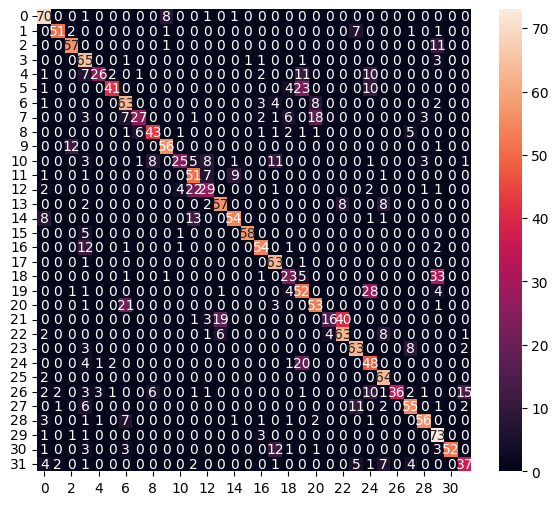

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.86      0.78        81
           1       0.91      0.81      0.86        63
           2       0.78      0.83      0.80        69
           3       0.52      0.90      0.66        72
           4       0.84      0.43      0.57        60
           5       0.89      0.52      0.66        79
           6       0.60      0.78      0.68        81
           7       0.77      0.40      0.52        68
           8       0.75      0.69      0.72        62
           9       0.84      0.81      0.82        69
          10       0.78      0.37      0.51        67
          11       0.53      0.73      0.61        70
          12       0.56      0.47      0.51        62
          13       0.69      0.74      0.71        77
          14       0.82      0.70      0.76        77
          15       0.98      0.91      0.94        64
          16       0.79      0.76      0.78        71
     

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path)

c:\Users\zeins\anaconda3\envs\lsl\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmpz60cddhn\assets


INFO:tensorflow:Assets written to: C:\Users\zeins\AppData\Local\Temp\tmpz60cddhn\assets


7788

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.4648753e-06 1.0699738e-05 1.8000719e-08 6.9362804e-06 5.0068665e-03
 3.2038445e-04 4.0261138e-02 6.4243749e-02 4.2985298e-02 1.3431763e-06
 1.1300891e-01 7.9687454e-02 6.2761359e-02 1.4997820e-03 4.8564434e-02
 4.4061649e-03 2.3956116e-05 3.4126479e-02 3.7513706e-03 1.5276417e-03
 9.2058182e-02 1.9830237e-03 1.4207467e-03 1.1611349e-04 3.4689758e-04
 1.5235752e-03 7.8930967e-03 2.4483104e-03 3.6021367e-01 2.0253341e-05
 2.4846895e-02 4.9339617e-03]
28
CPU times: total: 0 ns
Wall time: 1 ms
